In [1]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import os
import seaborn as sns
from wordcloud import WordCloud

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [3]:
#!pip install wordcloud

In [4]:
df=pd.read_csv('/content/gdrive/My Drive/data_updated_phish.csv')

print(df.shape)
df.head()

(165198, 2)


,url,type
0,br-icloud.com.br,phishing
1,signin.eby.de.zukruygxctzmmqi.civpro.co.za,phishing
2,http://www.marketingbyinternet.com/mo/e56508df...,phishing
3,https://docs.google.com/spreadsheet/viewform?f...,phishing
4,retajconsultancy.com,phishing


In [5]:
df.type.value_counts()

benign        101612
defacement     23709
phishing       22942
malware        16935
Name: type, dtype: int64

## Word Cloud

In [6]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']

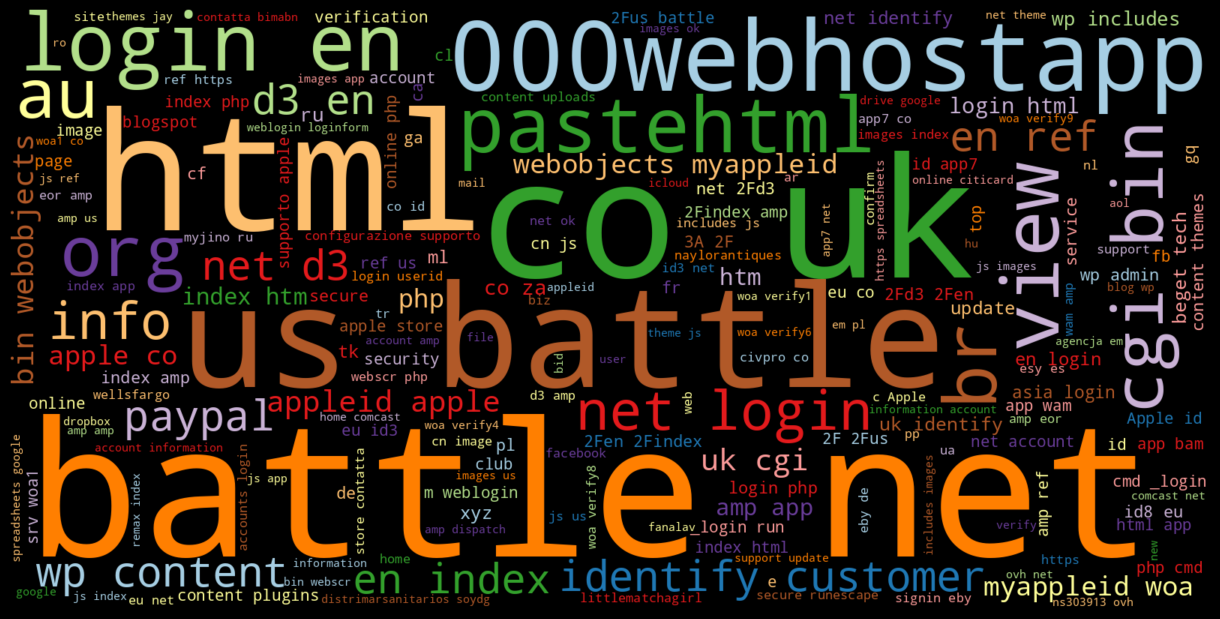

In [7]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

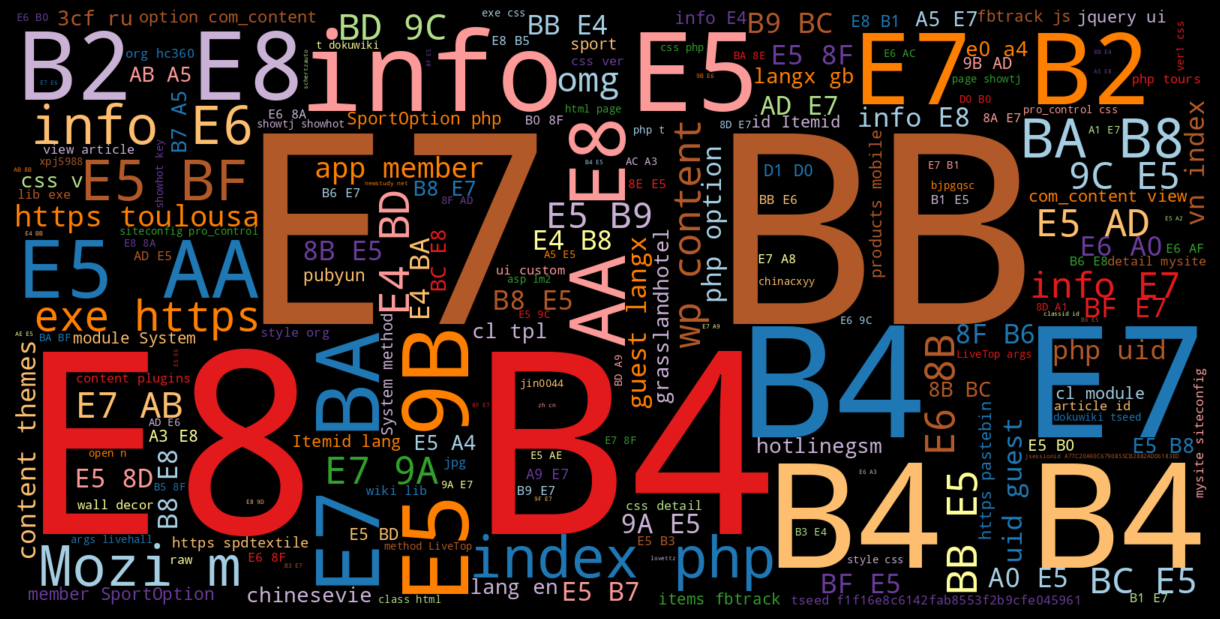

In [8]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

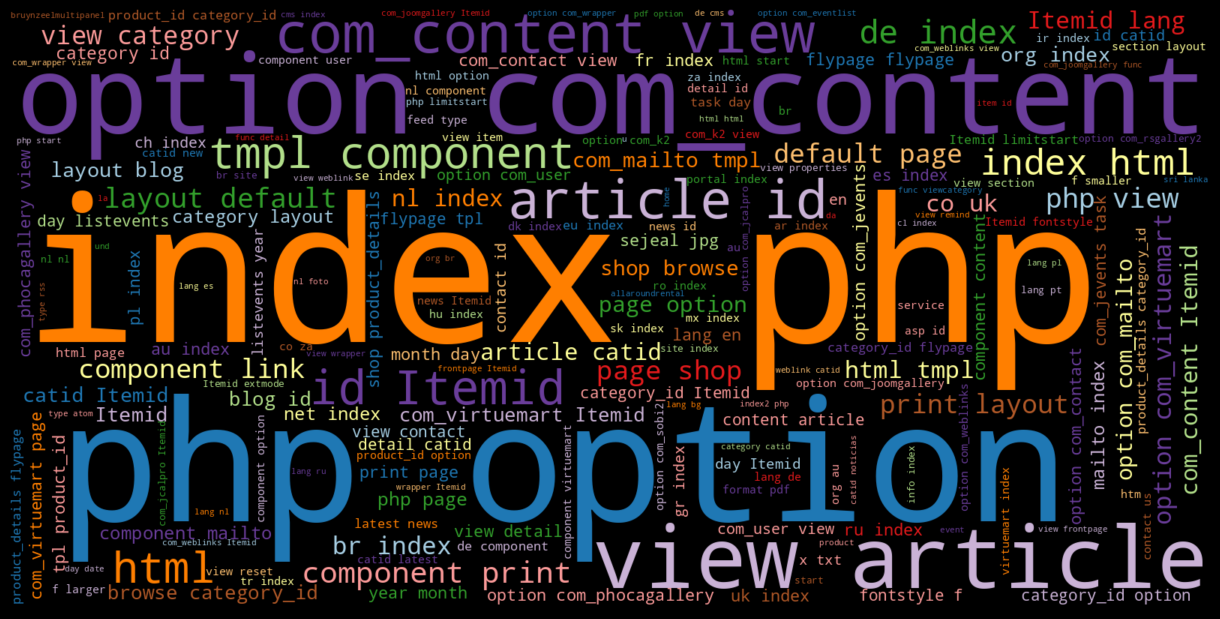

In [9]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

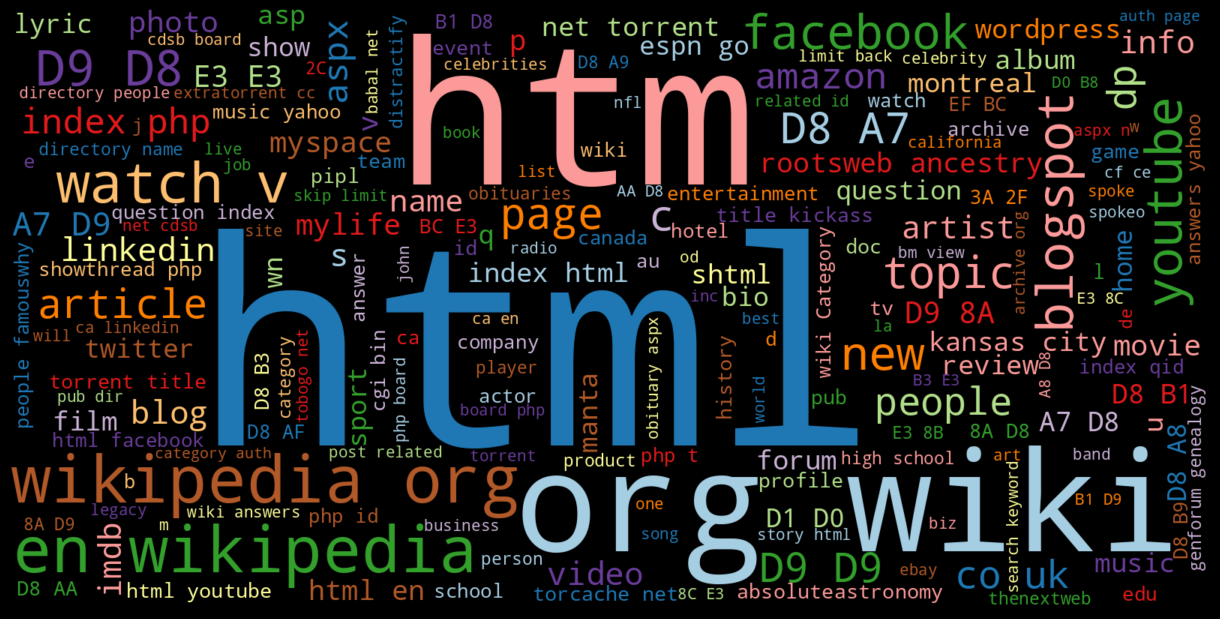

In [10]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Feature Engineering

In [11]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [12]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [13]:
#!pip install googlesearch-python

In [14]:
from googlesearch import search

In [15]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [16]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,signin.eby.de.zukruygxctzmmqi.civpro.co.za,phishing,0,0,1,6
2,http://www.marketingbyinternet.com/mo/e56508df...,phishing,0,1,1,2
3,https://docs.google.com/spreadsheet/viewform?f...,phishing,0,1,1,2
4,retajconsultancy.com,phishing,0,0,1,1


In [17]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):
     
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [18]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [19]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))
def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,signin.eby.de.zukruygxctzmmqi.civpro.co.za,phishing,0,0,1,6,0,0,0,0,...,0,0,0,0,0,42,0,1,0,36
2,http://www.marketingbyinternet.com/mo/e56508df...,phishing,0,1,1,2,1,0,3,0,...,1,0,0,0,0,71,27,0,17,46
3,https://docs.google.com/spreadsheet/viewform?f...,phishing,0,1,1,2,0,0,2,0,...,1,0,1,0,1,87,15,0,5,73
4,retajconsultancy.com,phishing,0,0,1,1,0,0,0,0,...,0,0,0,0,0,20,0,0,0,19


In [20]:
!pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 17.5 MB/s eta 0:00:00


In [21]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [22]:
df = df.drop("tld",1)

<ipython-input-22-beaedf415f7f>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("tld",1)


In [23]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [24]:
df['type'].value_counts()

benign        101612
defacement     23709
phishing       22942
malware        16935
Name: type, dtype: int64

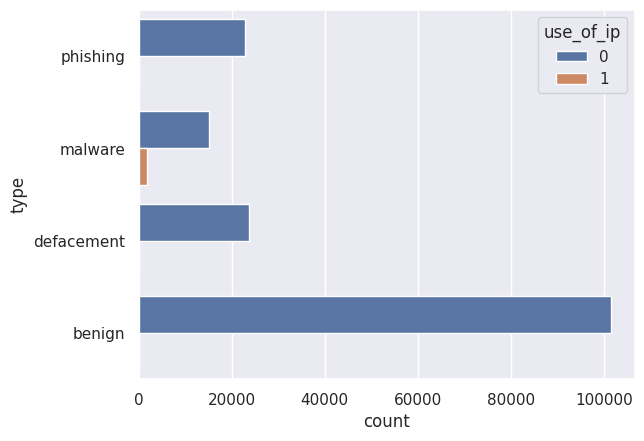

In [25]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")

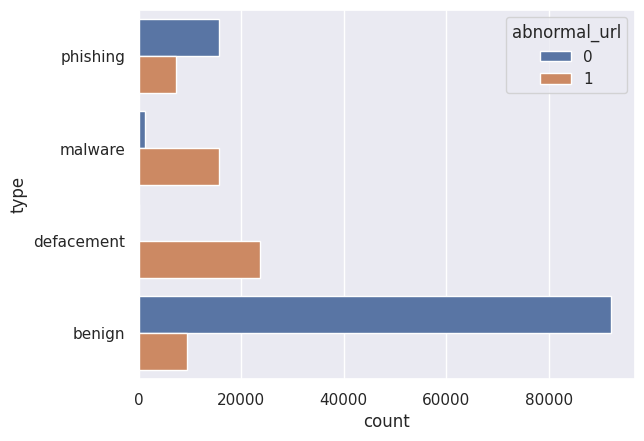

In [26]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")

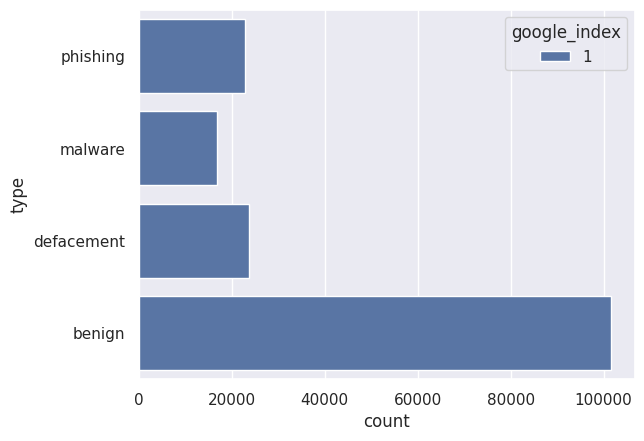

In [27]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="google_index")

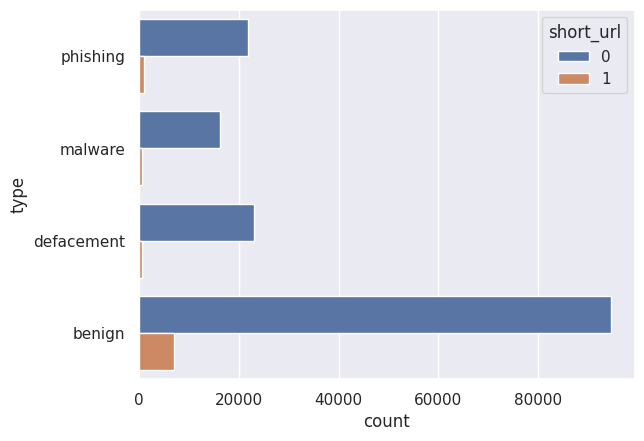

In [28]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="short_url")

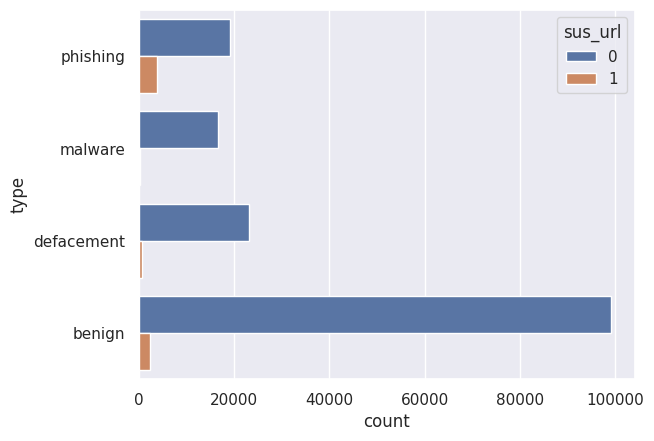

In [29]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="sus_url")

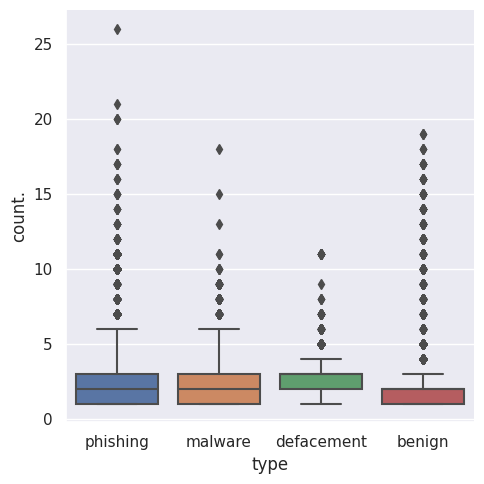

In [30]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count.", kind="box", data=df)

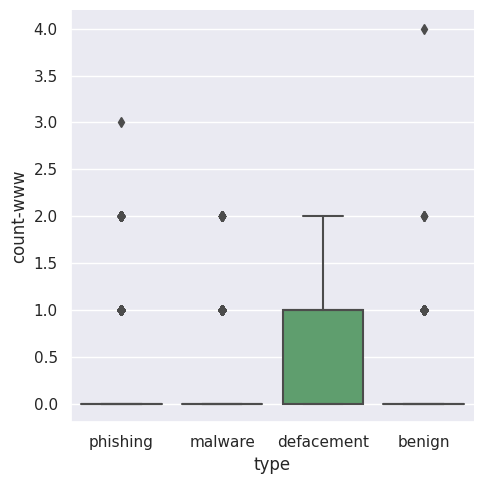

In [31]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-www", kind="box", data=df)

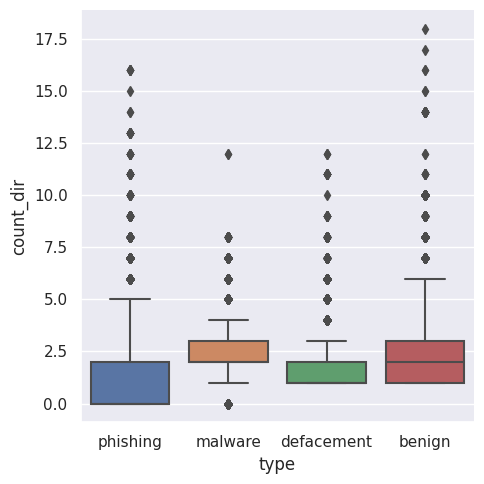

In [32]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df)

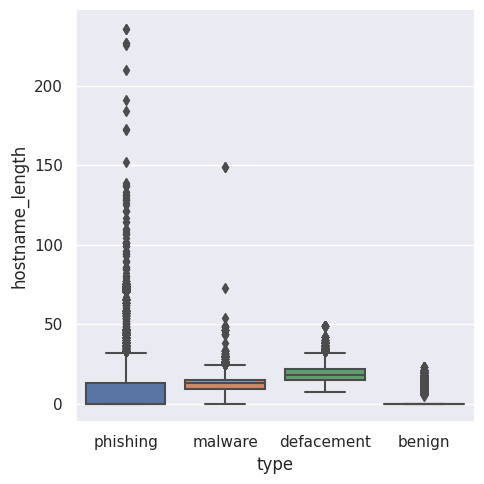

In [33]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

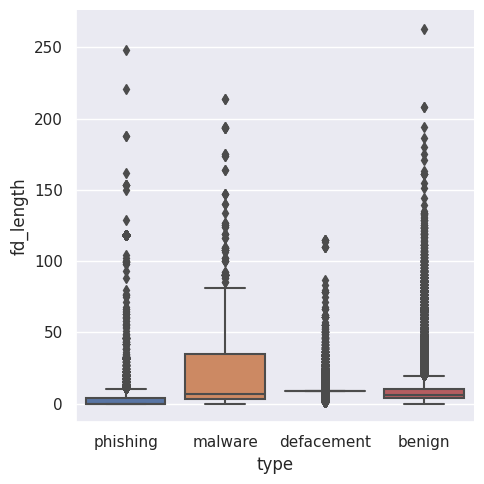

In [34]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df)

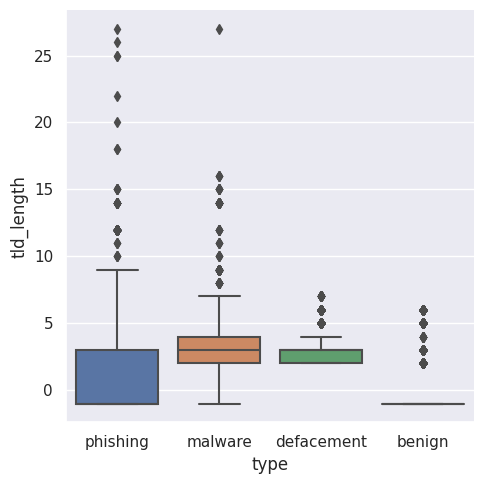

In [35]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df)

## Target Encoding

In [36]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    101612
1     23709
3     22942
2     16935
Name: type_code, dtype: int64

## Test Train split

In [37]:
#Predictor Variables
# filtering out google_index and use of IP as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [38]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,6,0,0,0,0,0,0,0,...,0,0,0,42,0,1,0,-1,0,36
2,0,1,2,1,0,3,0,1,0,1,...,0,0,0,71,27,0,2,3,17,46
3,0,1,2,0,0,2,0,0,1,1,...,1,0,1,87,15,0,11,3,5,73
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,20,0,0,0,-1,0,19


In [39]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [41]:
print(X_train.shape)
print(X_test.shape)

(132158, 21)
(33040, 21)


## Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

score = accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     20323
  defacement       0.97      0.99      0.98      4742
    phishing       0.99      0.92      0.95      3387
     malware       0.95      0.97      0.96      4588

    accuracy                           0.99     33040
   macro avg       0.98      0.97      0.97     33040
weighted avg       0.99      0.99      0.99     33040

accuracy:   0.985


In [57]:
# calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred_rf, average="weighted")
recall = recall_score(y_test, y_pred_rf, average="weighted")
f1 = f1_score(y_test, y_pred_rf, average="weighted")

print('Precision:  %0.3f' % precision)
print('Recall: %0.3f' % recall)
print('F1 score: %0.3f' % f1)

Precision:  0.985
Recall: 0.985
F1 score: 0.985


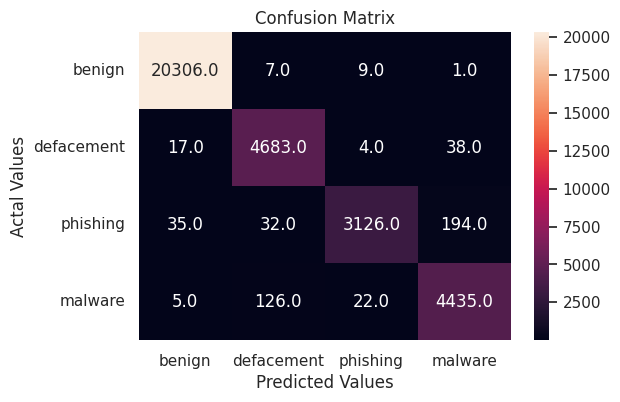

In [43]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Gaussian Naive Bayes

In [44]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

print(classification_report(y_test,y_pred_gnb,target_names=['benign', 'defacement','phishing','malware']))


score = accuracy_score(y_test, y_pred_gnb)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.85      0.89      0.87     20323
  defacement       0.54      1.00      0.70      4742
    phishing       0.69      0.44      0.54      3387
     malware       0.55      0.12      0.20      4588

    accuracy                           0.75     33040
   macro avg       0.66      0.61      0.58     33040
weighted avg       0.75      0.75      0.72     33040

accuracy:   0.752


In [58]:
# calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred_gnb, average="weighted")
recall = recall_score(y_test, y_pred_gnb, average="weighted")
f1 = f1_score(y_test, y_pred_gnb, average="weighted")

print('Precision:  %0.3f' % precision)
print('Recall: %0.3f' % recall)
print('F1 score: %0.3f' % f1)

Precision:  0.751
Recall: 0.752
F1 score: 0.720


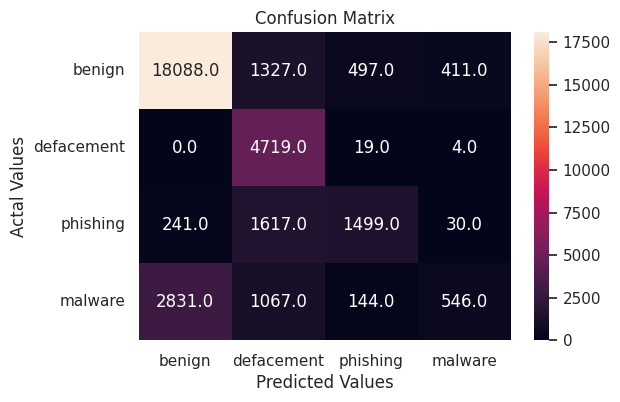

In [45]:
cm = confusion_matrix(y_test, y_pred_gnb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## K Nearest Neighbors

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print(classification_report(y_test,y_pred_knn,target_names=['benign', 'defacement','phishing','malware']))


score = accuracy_score(y_test, y_pred_knn)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.99      0.99      0.99     20323
  defacement       0.90      0.95      0.92      4742
    phishing       0.93      0.87      0.90      3387
     malware       0.92      0.89      0.91      4588

    accuracy                           0.96     33040
   macro avg       0.94      0.93      0.93     33040
weighted avg       0.96      0.96      0.96     33040

accuracy:   0.961


In [59]:
# calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred_knn, average="weighted")
recall = recall_score(y_test, y_pred_knn, average="weighted")
f1 = f1_score(y_test, y_pred_knn, average="weighted")

print('Precision:  %0.3f' % precision)
print('Recall: %0.3f' % recall)
print('F1 score: %0.3f' % f1)

Precision:  0.961
Recall: 0.961
F1 score: 0.961


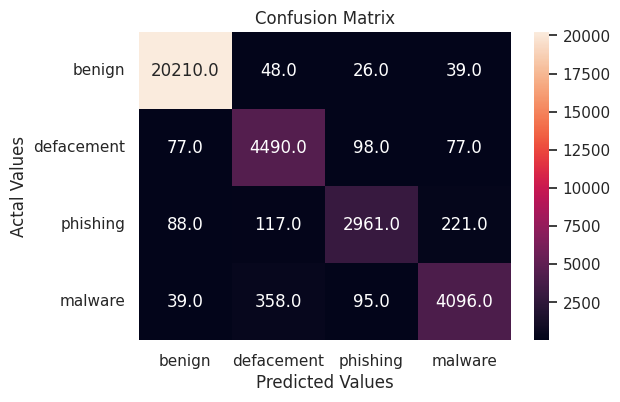

In [47]:
cm = confusion_matrix(y_test, y_pred_knn)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=7000)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

print(classification_report(y_test,y_pred_lr,target_names=['benign', 'defacement','phishing','malware']))


score = accuracy_score(y_test, y_pred_lr)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.97      0.97     20323
  defacement       0.78      0.89      0.83      4742
    phishing       0.76      0.69      0.73      3387
     malware       0.87      0.79      0.83      4588

    accuracy                           0.91     33040
   macro avg       0.85      0.84      0.84     33040
weighted avg       0.91      0.91      0.91     33040

accuracy:   0.907


In [62]:
# calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred_lr, average="weighted")
recall = recall_score(y_test, y_pred_lr, average="weighted")
f1 = f1_score(y_test, y_pred_lr, average="weighted")

print('Precision:  %0.3f' % precision)
print('Recall: %0.3f' % recall)
print('F1 score: %0.3f' % f1)

Precision:  0.907
Recall: 0.907
F1 score: 0.906


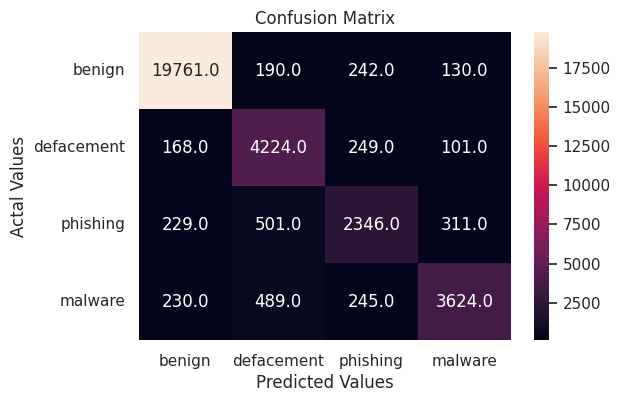

In [49]:
cm = confusion_matrix(y_test, y_pred_lr)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Decision Tree

In [50]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(classification_report(y_test,y_pred_dt,target_names=['benign', 'defacement','phishing','malware']))


score = accuracy_score(y_test, y_pred_dt)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     20323
  defacement       0.96      0.97      0.96      4742
    phishing       0.95      0.92      0.94      3387
     malware       0.93      0.95      0.94      4588

    accuracy                           0.98     33040
   macro avg       0.96      0.96      0.96     33040
weighted avg       0.98      0.98      0.98     33040

accuracy:   0.978


In [63]:
# calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred_dt, average="weighted")
recall = recall_score(y_test, y_pred_dt, average="weighted")
f1 = f1_score(y_test, y_pred_dt, average="weighted")

print('Precision:  %0.3f' % precision)
print('Recall: %0.3f' % recall)
print('F1 score: %0.3f' % f1)

Precision:  0.978
Recall: 0.978
F1 score: 0.978


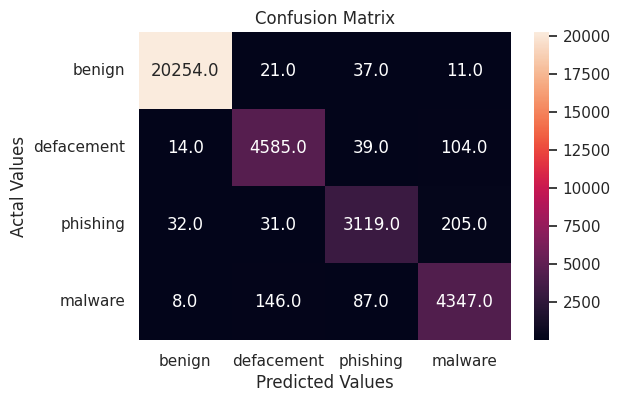

In [51]:
cm = confusion_matrix(y_test, y_pred_dt)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Support Vector Machines

In [52]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
ovo_model = OneVsOneClassifier(SVC())
ovo_model.fit(X_train, y_train)


y_pred_ovm = ovo_model.predict(X_test)

print(classification_report(y_test,y_pred_ovm,target_names=['benign', 'defacement','phishing','malware']))


score = accuracy_score(y_test, y_pred_ovm)
print("accuracy:   %0.3f" % score)


              precision    recall  f1-score   support

      benign       0.98      0.99      0.99     20323
  defacement       0.77      0.93      0.84      4742
    phishing       0.83      0.66      0.73      3387
     malware       0.90      0.79      0.84      4588

    accuracy                           0.92     33040
   macro avg       0.87      0.84      0.85     33040
weighted avg       0.92      0.92      0.92     33040

accuracy:   0.920


In [61]:
# calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred_ovm, average="weighted")
recall = recall_score(y_test, y_pred_ovm, average="weighted")
f1 = f1_score(y_test, y_pred_ovm, average="weighted")

print('Precision:  %0.3f' % precision)
print('Recall: %0.3f' % recall)
print('F1 score: %0.3f' % f1)

Precision:  0.922
Recall: 0.920
F1 score: 0.918


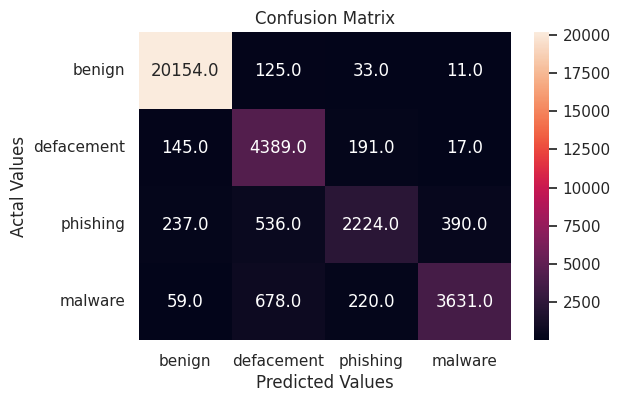

In [53]:
cm = confusion_matrix(y_test, y_pred_ovm)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Classifier Accuracy Comparison

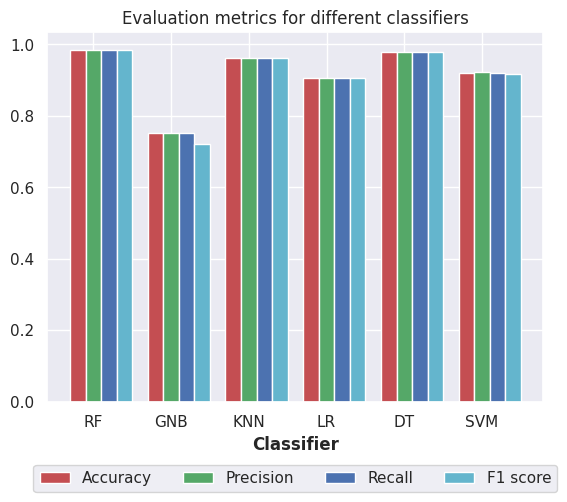

In [64]:
# Define the classifiers and their corresponding accuracy scores
classifiers = ['RF','GNB','KNN','LR', 'DT',  'SVM']
accuracy = [0.985,  0.752, 0.961, 0.907, 0.978, 0.92]
precision = [0.985,0.751,0.961,0.907,0.978,0.922]
recall = [0.985,0.752,0.961,0.907,0.978,0.92]
f1_score = [0.985,0.720,0.961,0.906,0.978,0.918]

# Set the width of the bars
barWidth = 0.2

# Set the position of the bars on the x-axis
r1 = range(len(classifiers))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Create the bar plot
plt.bar(r1, accuracy, color='r', width=barWidth, edgecolor='white', label='Accuracy')
plt.bar(r2, precision, color='g', width=barWidth, edgecolor='white', label='Precision')
plt.bar(r3, recall, color='b', width=barWidth, edgecolor='white', label='Recall')
plt.bar(r4, f1_score, color='c', width=barWidth, edgecolor='white', label='F1 score')

# Add xticks on the middle of the group bars
plt.xlabel('Classifier', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(classifiers))], classifiers)

# Add a legend and title
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.title('Evaluation metrics for different classifiers')

# Show the plot
plt.show()